# Gesture Recognition - Aman, Nurul, Prakash & Tim
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [9]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [10]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [11]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [13]:
project_folder='Project_data'

##### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [20]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [21]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

In [23]:
#test_generator=ModelConv3D1()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,15,:,:,:])   
#axes[1].imshow(batch_data[3,15,:,:,:])   

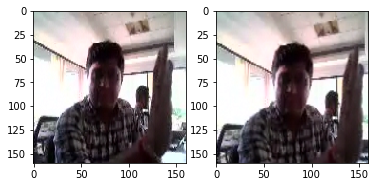

## Experimenting with Image resolution, number of frames to use and batch_size

In [24]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [25]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 55s 2s/step - loss: 1.4515 - categorical_accuracy: 0.4896 - val_loss: 2.1267 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2019-03-1614_29_03.145561/model-00001-1.45801-0.48265-2.12671-0.45000.h5
Epoch 2/3
23/23 [==============================] - 47s 2s/step - loss: 1.1673 - categorical_accuracy: 0.5589 - val_loss: 1.7071 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2019-03-1614_29_03.145561/model-00002-1.11328-0.58069-1.70707-0.43000.h5
Epoch 3/3
23/23 [==============================] - 49s 2s/step - loss: 0.9084 - categorical_accuracy: 0.6414 - val_loss: 2.4938 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2019-03-1614_29_03.145561/model-00003-0.93602-0.62745-2.49375-0.35000.h5


In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 163s 7s/step - loss: 1.6673 - categorical_accuracy: 0.3934 - val_loss: 1.7380 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2019-03-1614_31_43.431128/model-00001-1.64054-0.40875-1.73800-0.34000.h5
Epoch 2/2
23/23 [==============================] - 73s 3s/step - loss: 1.1597 - categorical_accuracy: 0.5413 - val_loss: 1.2833 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2019-03-1614_31_43.431128/model-00002-1.18737-0.52338-1.28326-0.46000.h5


In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 92s 8s/step - loss: 1.7903 - categorical_accuracy: 0.3641 - val_loss: 1.2608 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2019-03-1614_35_49.015853/model-00001-1.81611-0.36652-1.26084-0.49000.h5
Epoch 2/2
12/12 [==============================] - 71s 6s/step - loss: 1.1741 - categorical_accuracy: 0.5227 - val_loss: 1.0939 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2019-03-1614_35_49.015853/model-00002-1.21444-0.51131-1.09390-0.50000.h5


In [29]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 50s 4s/step - loss: 1.6570 - categorical_accuracy: 0.3996 - val_loss: 1.4679 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2019-03-1614_38_46.833789/model-00001-1.71621-0.37858-1.46788-0.51000.h5
Epoch 2/2
12/12 [==============================] - 36s 3s/step - loss: 1.2933 - categorical_accuracy: 0.4991 - val_loss: 1.3049 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2019-03-1614_38_46.833789/model-00002-1.17992-0.53846-1.30490-0.45000.h5


In [30]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 50s 6s/step - loss: 1.7385 - categorical_accuracy: 0.3560 - val_loss: 4.0362 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2019-03-1614_40_25.251994/model-00001-1.77623-0.34992-4.03619-0.28000.h5
Epoch 2/2
9/9 [==============================] - 35s 4s/step - loss: 1.1918 - categorical_accuracy: 0.5322 - val_loss: 4.4454 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2019-03-1614_40_25.251994/model-00002-1.13833-0.54299-4.44542-0.30000.h5


In [31]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 99s 2s/step - loss: 1.6126 - categorical_accuracy: 0.4088 - val_loss: 0.8895 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2019-03-1614_42_04.666932/model-00001-1.62168-0.40422-0.88947-0.67000.h5
Epoch 2/2
45/45 [==============================] - 84s 2s/step - loss: 1.1739 - categorical_accuracy: 0.5379 - val_loss: 0.9146 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2019-03-1614_42_04.666932/model-00002-1.17226-0.54148-0.91455-0.66000.h5


In [32]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 53s 1s/step - loss: 1.6318 - categorical_accuracy: 0.4061 - val_loss: 1.1419 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2019-03-1614_45_19.479759/model-00001-1.62347-0.41327-1.14188-0.55000.h5
Epoch 2/2
45/45 [==============================] - 44s 983ms/step - loss: 1.0648 - categorical_accuracy: 0.5658 - val_loss: 1.1721 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-03-1614_45_19.479759/model-00002-1.07743-0.55807-1.17206-0.60000.h5


In [33]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - 43s 959ms/step - loss: 1.7223 - categorical_accuracy: 0.3556 - val_loss: 2.5921 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2019-03-1614_47_07.828530/model-00001-1.72619-0.35596-2.59209-0.24000.h5
Epoch 2/2
45/45 [==============================] - 33s 737ms/step - loss: 1.2379 - categorical_accuracy: 0.5230 - val_loss: 2.1007 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2019-03-1614_47_07.828530/model-00002-1.22910-0.52640-2.10070-0.36000.h5


In [34]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 44s 650ms/step - loss: 1.5841 - categorical_accuracy: 0.4144 - val_loss: 1.8234 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2019-03-1614_48_36.323543/model-00001-1.58654-0.41176-1.82336-0.43000.h5
Epoch 2/2
67/67 [==============================] - 34s 508ms/step - loss: 1.3479 - categorical_accuracy: 0.4596 - val_loss: 0.8982 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2019-03-1614_48_36.323543/model-00002-1.35973-0.45400-0.89816-0.62000.h5


In [35]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 79s 1s/step - loss: 1.6217 - categorical_accuracy: 0.4323 - val_loss: 1.1418 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2019-03-1614_50_06.750693/model-00001-1.62279-0.42986-1.14185-0.58000.h5
Epoch 2/2
67/67 [==============================] - 68s 1s/step - loss: 1.2239 - categorical_accuracy: 0.5299 - val_loss: 1.2135 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2019-03-1614_50_06.750693/model-00002-1.20968-0.53544-1.21353-0.54000.h5


In [36]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 95s 1s/step - loss: 1.5623 - categorical_accuracy: 0.4069 - val_loss: 1.8928 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2019-03-1614_52_46.202017/model-00001-1.56677-0.40422-1.89278-0.30000.h5
Epoch 2/2
67/67 [==============================] - 79s 1s/step - loss: 1.2894 - categorical_accuracy: 0.5219 - val_loss: 0.9455 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2019-03-1614_52_46.202017/model-00002-1.28746-0.52036-0.94555-0.66000.h5


In [37]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 53s 790ms/step - loss: 1.6596 - categorical_accuracy: 0.3677 - val_loss: 1.1056 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2019-03-1614_58_22.784838/model-00001-1.66112-0.36802-1.10557-0.55000.h5
Epoch 2/2
67/67 [==============================] - 42s 630ms/step - loss: 1.3546 - categorical_accuracy: 0.4696 - val_loss: 1.0475 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2019-03-1614_58_22.784838/model-00002-1.35939-0.46757-1.04752-0.58000.h5


In [38]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - 60s 4s/step - loss: 1.6747 - categorical_accuracy: 0.3830 - val_loss: 0.9994 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2019-03-1615_00_11.348675/model-00001-1.68751-0.37858-0.99945-0.58000.h5
Epoch 2/2
17/17 [==============================] - 35s 2s/step - loss: 1.0526 - categorical_accuracy: 0.5903 - val_loss: 0.8694 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2019-03-1615_00_11.348675/model-00002-1.05775-0.58673-0.86944-0.66000.h5


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [69]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [70]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_50 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 10, 80, 80, 32)    128       
__________

In [71]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 72s 4s/step - loss: 1.6484 - categorical_accuracy: 0.3793 - val_loss: 3.5821 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2019-03-1007_29_09.439229/model-00001-1.65039-0.38009-3.58210-0.28000.h5
Epoch 2/15
17/17 [==============================] - 52s 3s/step - loss: 1.0203 - categorical_accuracy: 0.6001 - val_loss: 1.3206 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2019-03-1007_29_09.439229/model-00002-1.01788-0.59879-1.32063-0.55000.h5
Epoch 3/15
17/17 [==============================] - 61s 4s/step - loss: 0.7766 - categorical_accuracy: 0.7011 - val_loss: 0.8526 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2019-03-1007_29_09.439229/model-00003-0.77347-0.70437-0.85258-0.65000.h5
Epoch 4/15
17/17 [==============================] - 61s 4s/step - loss: 0.5859 - categorical_accuracy: 0.7809 - val_loss: 0.9037 - val_categoric

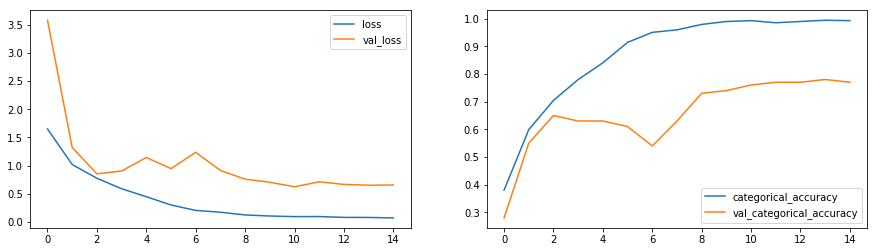

In [72]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [59]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_38 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 10, 80, 80, 32)    128       
__________

In [60]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 145s 4s/step - loss: 1.9434 - categorical_accuracy: 0.3988 - val_loss: 1.3561 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2019-03-1005_42_21.065484/model-00001-1.94407-0.40045-1.35607-0.55000.h5
Epoch 2/25
34/34 [==============================] - 128s 4s/step - loss: 1.4510 - categorical_accuracy: 0.5247 - val_loss: 2.0266 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2019-03-1005_42_21.065484/model-00002-1.44054-0.52112-2.02662-0.47000.h5
Epoch 3/25
34/34 [==============================] - 134s 4s/step - loss: 1.1826 - categorical_accuracy: 0.5861 - val_loss: 1.1703 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2019-03-1005_42_21.065484/model-00003-1.16885-0.58824-1.17029-0.67000.h5
Epoch 4/25
34/34 [==============================] - 135s 4s/step - loss: 1.0443 - categorical_accuracy: 0.6181 - val_loss: 0.8861 - val_categ

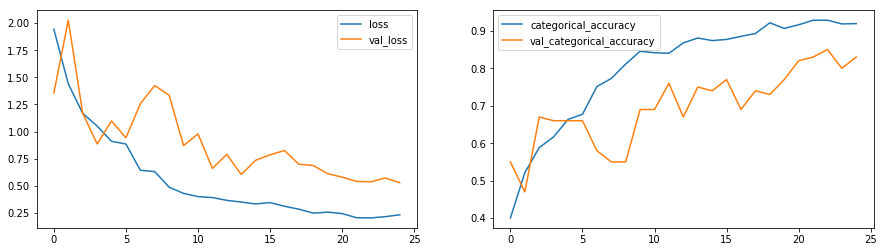

In [61]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [8]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_26 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 60, 60, 32)     128       
__________

In [20]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 97s 4s/step - loss: 2.1588 - categorical_accuracy: 0.3378 - val_loss: 1.2613 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2019-03-1115_20_32.906637/model-00001-2.18973-0.32504-1.26131-0.60000.h5
Epoch 2/30
23/23 [==============================] - 86s 4s/step - loss: 1.5574 - categorical_accuracy: 0.4451 - val_loss: 1.0693 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2019-03-1115_20_32.906637/model-00002-1.54651-0.44947-1.06930-0.62000.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 1.4757 - categorical_accuracy: 0.4930 - val_loss: 0.8723 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2019-03-1115_20_32.906637/model-00003-1.43319-0.49925-0.87225-0.67000.h5
Epoch 4/30
23/23 [==============================] - 88s 4s/step - loss: 1.2460 - categorical_accuracy: 0.5775 - val_loss: 0.7799 - val_categoric

23/23 [==============================] - 88s 4s/step - loss: 0.4327 - categorical_accuracy: 0.8428 - val_loss: 0.6439 - val_categorical_accuracy: 0.8300

Epoch 00030: saving model to model_init_2019-03-1115_20_32.906637/model-00030-0.41932-0.84314-0.64393-0.83000.h5


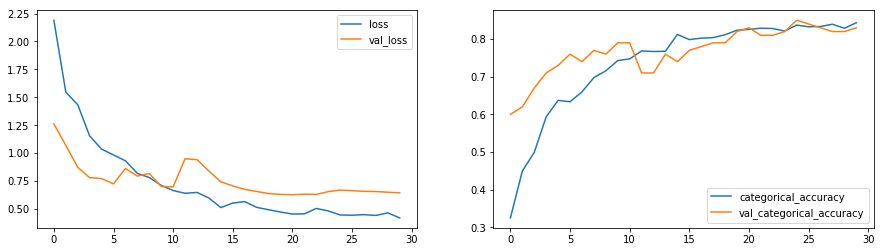

In [21]:
plot(history_model3)

##### Model has a  best validation accuracy of 84% and training accuracy of 84% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [7]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [9]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 209s 6s/step - loss: 2.0704 - categorical_accuracy: 0.3400 - val_loss: 3.7693 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2019-03-1008_46_09.184617/model-00001-2.03959-0.34012-3.76934-0.36000.h5
Epoch 2/30
34/34 [==============================] - 97s 3s/step - loss: 1.5526 - categorical_accuracy: 0.4724 - val_loss: 3.8769 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2019-03-1008_46_09.184617/model-00002-1.50234-0.48416-3.87689-0.36000.h5
Epoch 3/30
34/34 [==============================] - 102s 3s/step - loss: 1.3620 - categorical_accuracy: 0.5364 - val_loss: 2.0781 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2019-03-1008_46_09.184617/model-00003-1.37034-0.53318-2.07815-0.49000.h5
Epoch 4/30
34/34 [==============================] - 102s 3s/step - loss: 1.2027 - categorical_accuracy: 0.5809 - val_loss: 2.5479 - val_catego

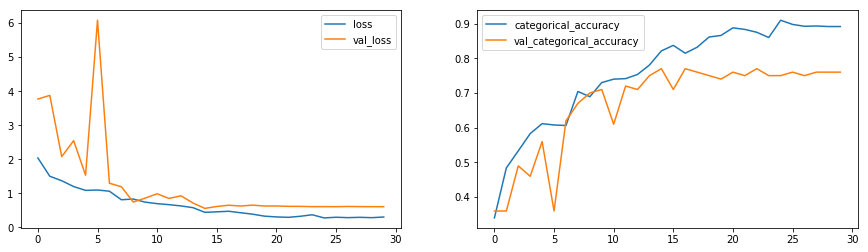

In [12]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [9]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [17]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 112s 3s/step - loss: 1.7839 - categorical_accuracy: 0.3775 - val_loss: 5.3131 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2019-03-1012_55_02.718281/model-00001-1.80713-0.37029-5.31309-0.33000.h5
Epoch 2/22
34/34 [==============================] - 92s 3s/step - loss: 1.2731 - categorical_accuracy: 0.5258 - val_loss: 2.0889 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2019-03-1012_55_02.718281/model-00002-1.28196-0.51810-2.08886-0.53000.h5
Epoch 3/22
34/34 [==============================] - 93s 3s/step - loss: 1.1038 - categorical_accuracy: 0.5806 - val_loss: 3.7566 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_2019-03-1012_55_02.718281/model-00003-1.11794-0.57843-3.75659-0.37000.h5
Epoch 4/22
34/34 [==============================] - 97s 3s/step - loss: 1.0271 - categorical_accuracy: 0.6015 - val_loss: 3.0447 - val_categori

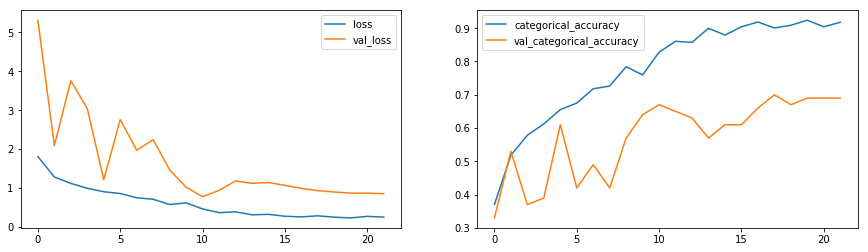

In [18]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [33]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_65 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_87 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_66 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_88 (Batc (None, 8, 50, 50, 32)     128       
__________

In [35]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 85s 2s/step - loss: 1.8024 - categorical_accuracy: 0.3304 - val_loss: 1.2390 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2019-03-1014_58_54.727215/model-00001-1.80901-0.33032-1.23904-0.52000.h5
Epoch 2/30
34/34 [==============================] - 73s 2s/step - loss: 1.2119 - categorical_accuracy: 0.5375 - val_loss: 1.0104 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2019-03-1014_58_54.727215/model-00002-1.17422-0.54676-1.01044-0.63000.h5
Epoch 3/30
34/34 [==============================] - 80s 2s/step - loss: 0.9485 - categorical_accuracy: 0.6380 - val_loss: 0.8189 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2019-03-1014_58_54.727215/model-00003-0.94836-0.63725-0.81888-0.69000.h5
Epoch 4/30
34/34 [==============================] - 80s 2s/step - loss: 0.8501 - categorical_accuracy: 0.6560 - val_loss: 0.9353 - val_categorica

34/34 [==============================] - 80s 2s/step - loss: 0.2499 - categorical_accuracy: 0.9260 - val_loss: 0.6755 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2019-03-1014_58_54.727215/model-00030-0.23651-0.92836-0.67552-0.77000.h5


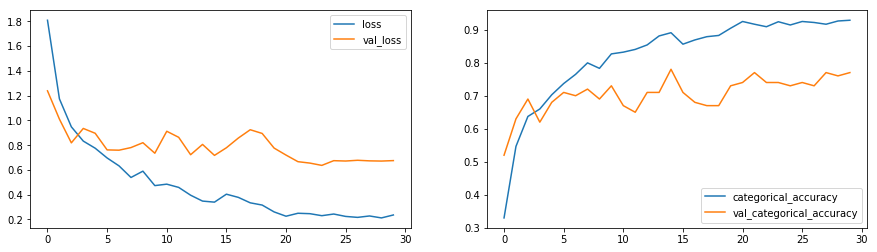

In [36]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 7 - reducing the number of parameters

In [28]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_62 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 8, 60, 60, 32)     128       
__________

In [31]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 94s 3s/step - loss: 1.9593 - categorical_accuracy: 0.3330 - val_loss: 1.7143 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2019-03-1014_21_25.841857/model-00001-1.96391-0.32881-1.71434-0.43000.h5
Epoch 2/25
34/34 [==============================] - 83s 2s/step - loss: 1.2913 - categorical_accuracy: 0.5088 - val_loss: 1.2703 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-03-1014_21_25.841857/model-00002-1.26297-0.51735-1.27031-0.60000.h5
Epoch 3/25
34/34 [==============================] - 88s 3s/step - loss: 1.1091 - categorical_accuracy: 0.5681 - val_loss: 0.8894 - val_categorical_accuracy: 0.7000

Epoch 00003: saving model to model_init_2019-03-1014_21_25.841857/model-00003-1.09435-0.57391-0.88939-0.70000.h5
Epoch 4/25
34/34 [==============================] - 89s 3s/step - loss: 0.9943 - categorical_accuracy: 0.6159 - val_loss: 1.0272 - val_categorica

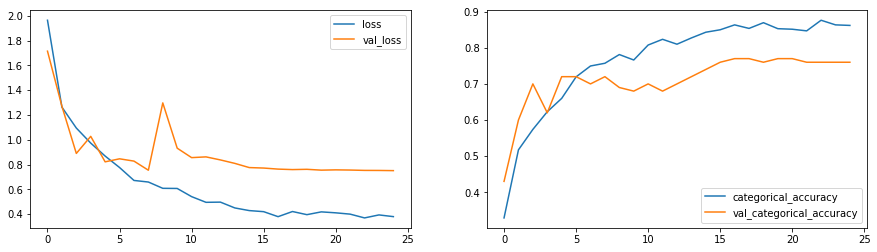

In [32]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 8 - reducing the number of parameters

In [8]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 16)     64        
__________

In [10]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 220s 6s/step - loss: 1.9751 - categorical_accuracy: 0.2984 - val_loss: 1.4932 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2019-03-1313_33_37.190087/model-00001-1.98941-0.29336-1.49321-0.42000.h5
Epoch 2/30
34/34 [==============================] - 88s 3s/step - loss: 1.4240 - categorical_accuracy: 0.4430 - val_loss: 1.1719 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2019-03-1313_33_37.190087/model-00002-1.42481-0.44570-1.17192-0.54000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.2560 - categorical_accuracy: 0.4967 - val_loss: 1.1260 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2019-03-1313_33_37.190087/model-00003-1.23420-0.50905-1.12604-0.56000.h5
Epoch 4/30
34/34 [==============================] - 91s 3s/step - loss: 1.1064 - categorical_accuracy: 0.5706 - val_loss: 1.0530 - val_categoric

34/34 [==============================] - 90s 3s/step - loss: 0.3807 - categorical_accuracy: 0.8745 - val_loss: 0.7095 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2019-03-1313_33_37.190087/model-00030-0.36469-0.87557-0.70946-0.77000.h5


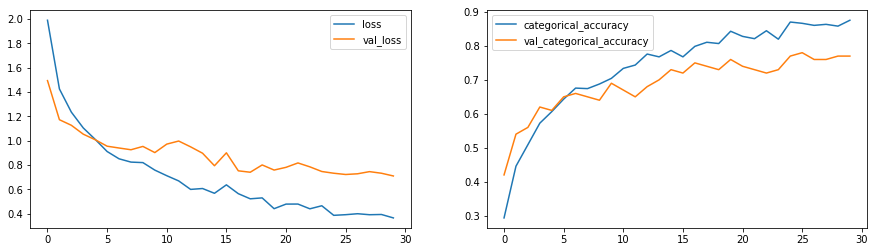

In [13]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 78%

# Model 9 - CNN- LSTM Model

In [8]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [13]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 185s 5s/step - loss: 1.4812 - categorical_accuracy: 0.3587 - val_loss: 1.3154 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2019-03-1105_50_41.913699/model-00001-1.47905-0.36350-1.31544-0.47000.h5
Epoch 2/20
34/34 [==============================] - 97s 3s/step - loss: 1.1502 - categorical_accuracy: 0.5394 - val_loss: 1.0631 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2019-03-1105_50_41.913699/model-00002-1.15262-0.53620-1.06311-0.47000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 1.1370 - categorical_accuracy: 0.5361 - val_loss: 1.9629 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2019-03-1105_50_41.913699/model-00003-1.13109-0.53695-1.96287-0.26000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.9926 - categorical_accuracy: 0.6155 - val_loss: 1.9898 - val_catego

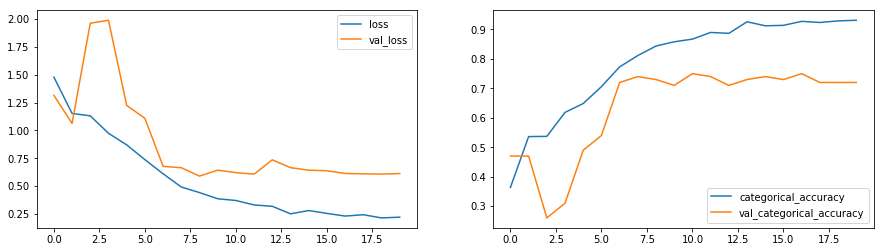

In [14]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 75%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [7]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [8]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [34]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)    128       
__________

In [11]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 242s 7s/step - loss: 2.0054 - categorical_accuracy: 0.3709 - val_loss: 1.4889 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2019-03-1515_38_46.998496/model-00001-2.00150-0.37179-1.48888-0.51000.h5
Epoch 2/30
34/34 [==============================] - 138s 4s/step - loss: 1.3446 - categorical_accuracy: 0.5364 - val_loss: 0.9051 - val_categorical_accuracy: 0.7200

Epoch 00002: saving model to model_init_2019-03-1515_38_46.998496/model-00002-1.31829-0.54148-0.90512-0.72000.h5
Epoch 3/30
34/34 [==============================] - 139s 4s/step - loss: 1.2107 - categorical_accuracy: 0.5843 - val_loss: 0.8590 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2019-03-1515_38_46.998496/model-00003-1.18664-0.59050-0.85905-0.72000.h5
Epoch 4/30
34/34 [==============================] - 140s 4s/step - loss: 1.0154 - categorical_accuracy: 0.6255 - val_loss: 0.8520 - val_categ

34/34 [==============================] - 140s 4s/step - loss: 0.3922 - categorical_accuracy: 0.8572 - val_loss: 0.5976 - val_categorical_accuracy: 0.8500

Epoch 00030: saving model to model_init_2019-03-1515_38_46.998496/model-00030-0.37248-0.86199-0.59757-0.85000.h5


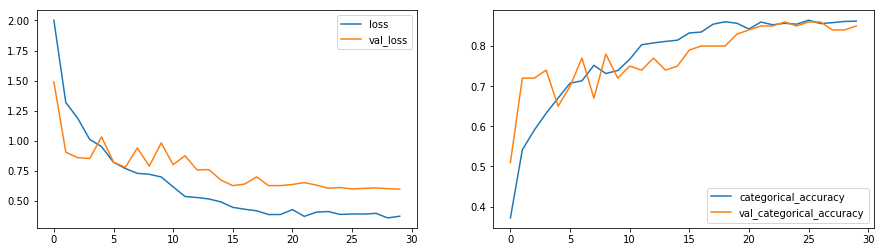

In [12]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [22]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 32)     128       
__________

In [24]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 96s 4s/step - loss: 2.3126 - categorical_accuracy: 0.3107 - val_loss: 1.1722 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2019-03-1610_29_13.078401/model-00001-2.37693-0.29035-1.17217-0.53000.h5
Epoch 2/30
23/23 [==============================] - 86s 4s/step - loss: 1.6542 - categorical_accuracy: 0.4392 - val_loss: 1.1440 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2019-03-1610_29_13.078401/model-00002-1.69388-0.42383-1.14399-0.56000.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 1.4634 - categorical_accuracy: 0.4940 - val_loss: 1.0317 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2019-03-1610_29_13.078401/model-00003-1.41239-0.50679-1.03166-0.61000.h5
Epoch 4/30
23/23 [==============================] - 89s 4s/step - loss: 1.2362 - categorical_accuracy: 0.5701 - val_loss: 0.9686 - val_categoric

23/23 [==============================] - 91s 4s/step - loss: 0.5336 - categorical_accuracy: 0.8008 - val_loss: 0.7835 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_init_2019-03-1610_29_13.078401/model-00030-0.49944-0.81900-0.78350-0.73000.h5


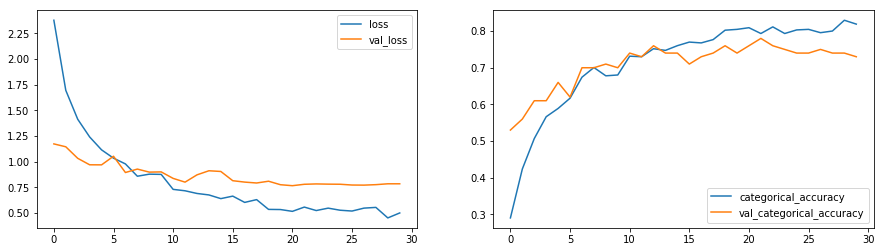

In [25]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [12]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [14]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 196s 6s/step - loss: 2.1942 - categorical_accuracy: 0.3160 - val_loss: 2.1050 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2019-03-1602_59_28.450657/model-00001-2.20448-0.31976-2.10499-0.36000.h5
Epoch 2/30
34/34 [==============================] - 96s 3s/step - loss: 1.6542 - categorical_accuracy: 0.4363 - val_loss: 1.7584 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2019-03-1602_59_28.450657/model-00002-1.64910-0.43891-1.75837-0.43000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.4116 - categorical_accuracy: 0.5007 - val_loss: 1.2344 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2019-03-1602_59_28.450657/model-00003-1.42322-0.50075-1.23443-0.54000.h5
Epoch 4/30
34/34 [==============================] - 99s 3s/step - loss: 1.2196 - categorical_accuracy: 0.5784 - val_loss: 1.6662 - val_categori


Epoch 00029: saving model to model_init_2019-03-1602_59_28.450657/model-00029-0.43063-0.85219-0.64634-0.80000.h5
Epoch 30/30
34/34 [==============================] - 98s 3s/step - loss: 0.4531 - categorical_accuracy: 0.8425 - val_loss: 0.6437 - val_categorical_accuracy: 0.7900

Epoch 00030: saving model to model_init_2019-03-1602_59_28.450657/model-00030-0.42906-0.84691-0.64368-0.79000.h5


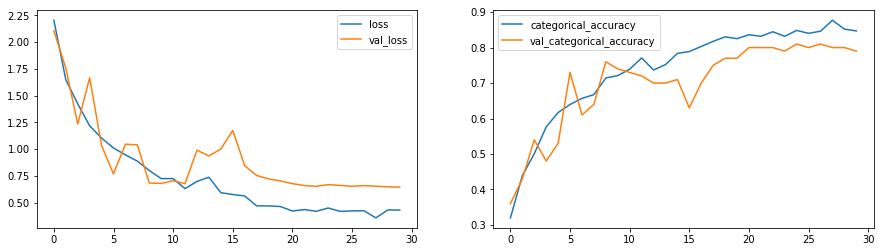

In [15]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [41]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_66 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [43]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 125s 4s/step - loss: 1.9786 - categorical_accuracy: 0.3300 - val_loss: 3.2322 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2019-03-1615_04_13.612627/model-00001-2.01066-0.31750-3.23223-0.19000.h5
Epoch 2/25
34/34 [==============================] - 98s 3s/step - loss: 1.6215 - categorical_accuracy: 0.4235 - val_loss: 3.7893 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2019-03-1615_04_13.612627/model-00002-1.62012-0.42157-3.78929-0.22000.h5
Epoch 3/25
34/34 [==============================] - 98s 3s/step - loss: 1.4399 - categorical_accuracy: 0.4606 - val_loss: 3.4880 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2019-03-1615_04_13.612627/model-00003-1.41740-0.47210-3.48800-0.23000.h5
Epoch 4/25
34/34 [==============================] - 98s 3s/step - loss: 1.3233 - categorical_accuracy: 0.4989 - val_loss: 3.1878 - val_categori

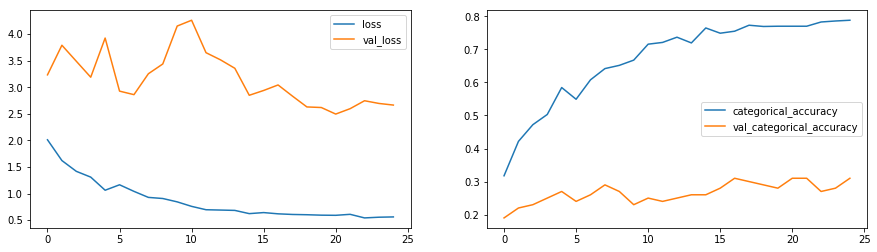

In [44]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [45]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [46]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_73 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_74 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 8, 50, 50, 32)     128       
__________

In [47]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 94s 3s/step - loss: 1.8539 - categorical_accuracy: 0.3322 - val_loss: 1.2226 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2019-03-1616_05_42.331421/model-00001-1.88243-0.32805-1.22261-0.51000.h5
Epoch 2/30
34/34 [==============================] - 75s 2s/step - loss: 1.2911 - categorical_accuracy: 0.5129 - val_loss: 1.0278 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2019-03-1616_05_42.331421/model-00002-1.25660-0.51735-1.02785-0.57000.h5
Epoch 3/30
34/34 [==============================] - 87s 3s/step - loss: 1.0534 - categorical_accuracy: 0.5927 - val_loss: 1.0887 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2019-03-1616_05_42.331421/model-00003-1.04921-0.59502-1.08865-0.59000.h5
Epoch 4/30
34/34 [==============================] - 86s 3s/step - loss: 0.9657 - categorical_accuracy: 0.6453 - val_loss: 0.9976 - val_categorica

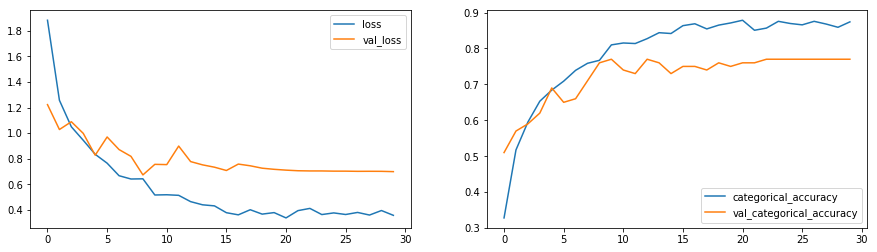

In [48]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [49]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_77 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_77 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_78 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 8, 60, 60, 32)     128       
__________

In [51]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 101s 3s/step - loss: 1.8962 - categorical_accuracy: 0.3216 - val_loss: 1.4599 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2019-03-1617_00_15.029524/model-00001-1.88427-0.32127-1.45992-0.48000.h5
Epoch 2/25
34/34 [==============================] - 82s 2s/step - loss: 1.3983 - categorical_accuracy: 0.4573 - val_loss: 1.2260 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2019-03-1617_00_15.029524/model-00002-1.38430-0.46456-1.22598-0.53000.h5
Epoch 3/25
34/34 [==============================] - 94s 3s/step - loss: 1.1682 - categorical_accuracy: 0.5368 - val_loss: 1.2060 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2019-03-1617_00_15.029524/model-00003-1.16263-0.53771-1.20604-0.57000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.0644 - categorical_accuracy: 0.5964 - val_loss: 1.0325 - val_categoric

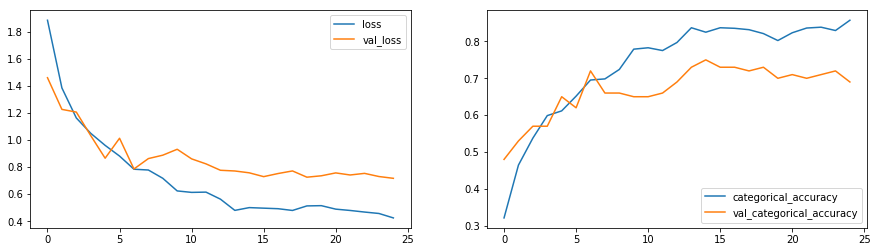

In [53]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [9]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 16)     64        
__________

In [11]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 188s 6s/step - loss: 1.9651 - categorical_accuracy: 0.2789 - val_loss: 1.3883 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2019-03-1607_47_08.840041/model-00001-1.98495-0.27753-1.38834-0.53000.h5
Epoch 2/30
34/34 [==============================] - 89s 3s/step - loss: 1.3860 - categorical_accuracy: 0.4853 - val_loss: 1.2226 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2019-03-1607_47_08.840041/model-00002-1.38607-0.48492-1.22261-0.53000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.3189 - categorical_accuracy: 0.5007 - val_loss: 1.0697 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2019-03-1607_47_08.840041/model-00003-1.30081-0.50075-1.06971-0.58000.h5
Epoch 4/30
34/34 [==============================] - 90s 3s/step - loss: 1.1629 - categorical_accuracy: 0.5331 - val_loss: 1.0790 - val_categoric


Epoch 00029: saving model to model_init_2019-03-1607_47_08.840041/model-00029-0.56069-0.78808-0.72675-0.74000.h5
Epoch 30/30
34/34 [==============================] - 87s 3s/step - loss: 0.5599 - categorical_accuracy: 0.7991 - val_loss: 0.7277 - val_categorical_accuracy: 0.7400

Epoch 00030: saving model to model_init_2019-03-1607_47_08.840041/model-00030-0.54447-0.80241-0.72770-0.74000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.


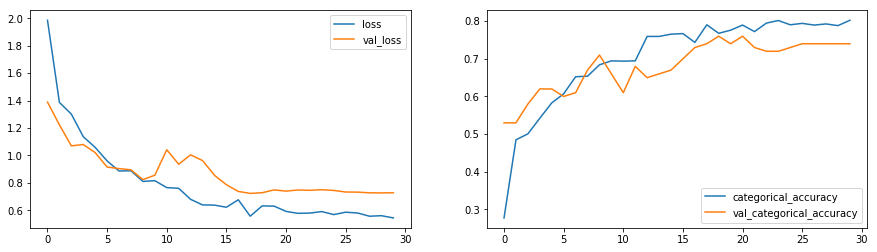

In [12]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [8]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [10]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 208s 6s/step - loss: 1.4934 - categorical_accuracy: 0.3418 - val_loss: 1.1111 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2019-03-1706_40_14.783128/model-00001-1.49392-0.34615-1.11110-0.62000.h5
Epoch 2/20
34/34 [==============================] - 100s 3s/step - loss: 1.0478 - categorical_accuracy: 0.5791 - val_loss: 0.9681 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2019-03-1706_40_14.783128/model-00002-1.05931-0.57692-0.96808-0.61000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.9091 - categorical_accuracy: 0.6472 - val_loss: 0.9252 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2019-03-1706_40_14.783128/model-00003-0.90214-0.65083-0.92517-0.65000.h5
Epoch 4/20
34/34 [==============================] - 103s 3s/step - loss: 0.7560 - categorical_accuracy: 0.7208 - val_loss: 0.9613 - val_categ

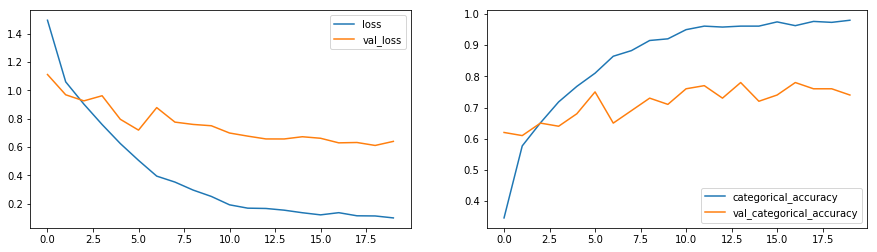

In [11]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [12]:
from keras.applications import mobilenet

In [18]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 3s 0us/step


In [19]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

In [20]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 89s 672ms/step - loss: 1.4922 - categorical_accuracy: 0.3306 - val_loss: 1.3094 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2019-03-1609_17_55.216031/model-00001-1.49357-0.32956-1.30941-0.44000.h5
Epoch 2/20
133/133 [==============================] - 83s 623ms/step - loss: 1.1750 - categorical_accuracy: 0.5208 - val_loss: 1.2151 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2019-03-1609_17_55.216031/model-00002-1.17305-0.52187-1.21509-0.48000.h5
Epoch 3/20
133/133 [==============================] - 83s 625ms/step - loss: 1.0349 - categorical_accuracy: 0.5985 - val_loss: 1.0923 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2019-03-1609_17_55.216031/model-00003-1.03466-0.59879-1.09227-0.55000.h5
Epoch 4/20
133/133 [==============================] - 86s 645ms/step - loss: 0.8913 - categorical_accuracy: 0.6526 - val_loss: 1.

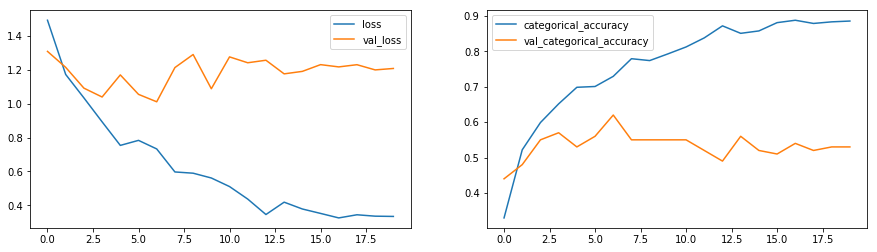

In [21]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [13]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 3s 0us/step


In [14]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [15]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 162s 1s/step - loss: 1.1821 - categorical_accuracy: 0.5341 - val_loss: 0.7234 - val_categorical_accuracy: 0.7200

Epoch 00001: saving model to model_init_2019-03-1707_22_23.192332/model-00001-1.18117-0.53469-0.72344-0.72000.h5
Epoch 2/20
133/133 [==============================] - 98s 739ms/step - loss: 0.7764 - categorical_accuracy: 0.6900 - val_loss: 0.5780 - val_categorical_accuracy: 0.8000

Epoch 00002: saving model to model_init_2019-03-1707_22_23.192332/model-00002-0.77337-0.69155-0.57802-0.80000.h5
Epoch 3/20
133/133 [==============================] - 100s 749ms/step - loss: 0.4840 - categorical_accuracy: 0.8088 - val_loss: 0.4712 - val_categorical_accuracy: 0.8300

Epoch 00003: saving model to model_init_2019-03-1707_22_23.192332/model-00003-0.48199-0.80920-0.47117-0.83000.h5
Epoch 4/20
133/133 [==============================] - 101s 757ms/step - loss: 0.4581 - categorical_accuracy: 0.8226 - val_loss: 0.

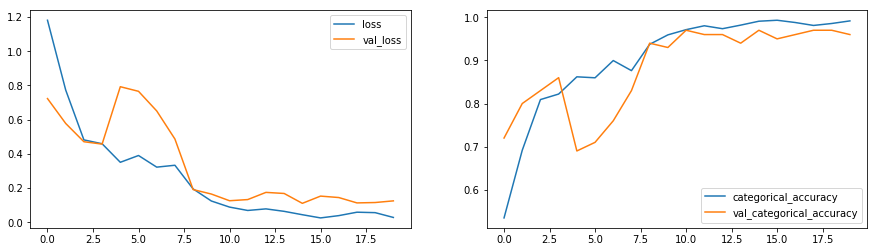

In [16]:
plot(history_model19)

# Consolidated Final Models

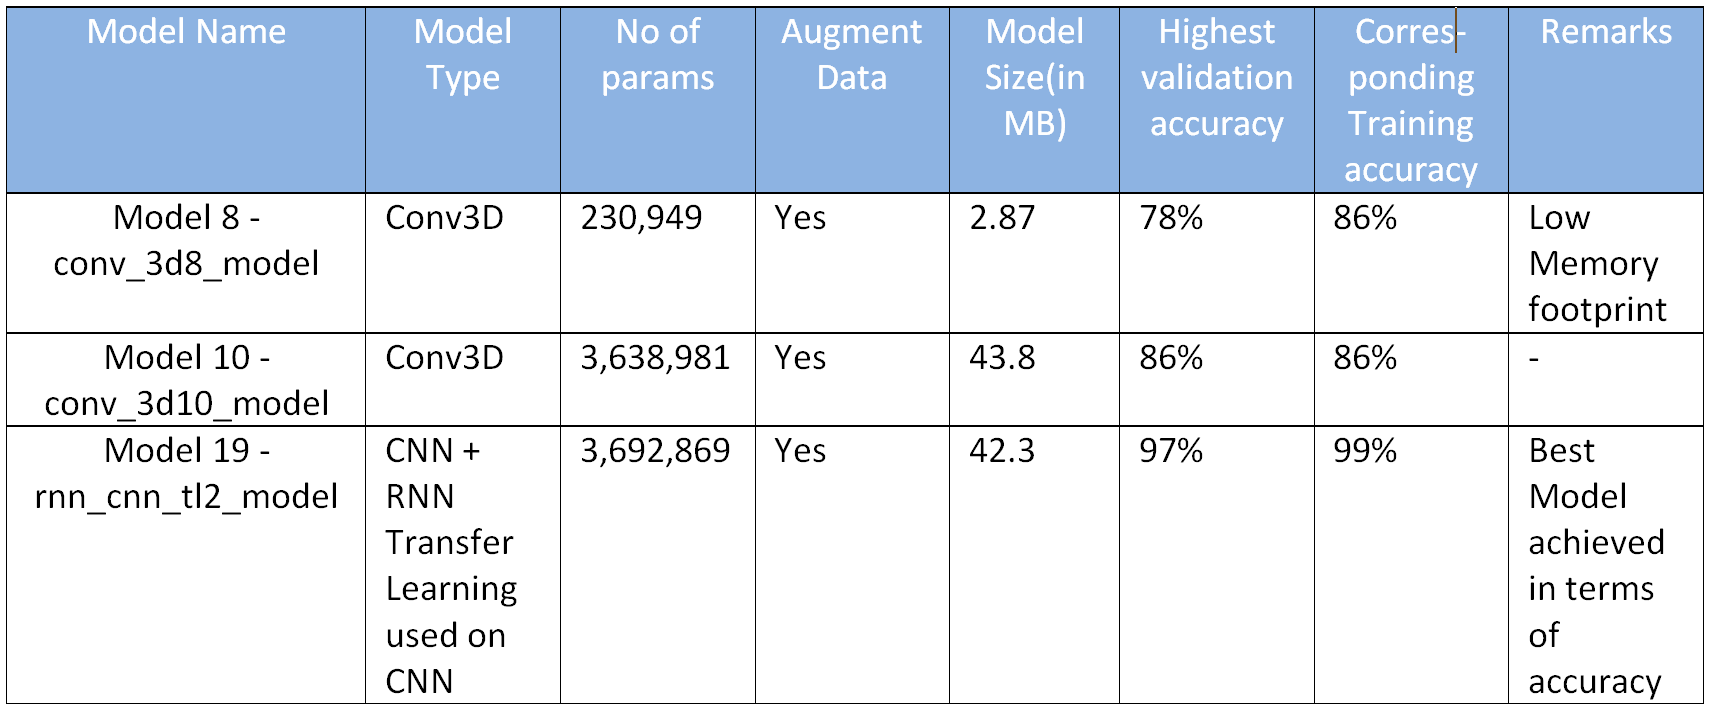

# Loading model and Testing

In [32]:
import time
from keras.models import load_model
model = load_model('conv3d_model-10-0.39118-0.86425-0.59927-0.86000.h5')

In [38]:
test_generator=ModelConv3D10()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [39]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [40]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 1 3 2 2]
